# Neural Transfer


Принцип прост: мы определяем два расстояния, одно для содержания DC и одно для стиля DS. DC измеряет, насколько отличается содержание двух изображений, а DS - насколько отличается стиль двух изображений. Затем мы берем третье изображение, входное, и преобразуем его так, чтобы минимизировать как расстояние между содержанием и изображением содержания, так и расстояние между стилем и изображением стиля

In [ ]:
!pip install pytorch_fid

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import glob
import random
import warnings

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
from pytorch_fid import fid_score

import copy

warnings.filterwarnings("ignore")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

Загрузка изображений

In [5]:
imsize = 256 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor(),])


In [ ]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("picasso.jpg")
content_img = image_loader("dancing.jpg")

assert style_img.size() == content_img.size(), \
    "неправильный формат"

In [90]:
unloader = transforms.ToPILImage()

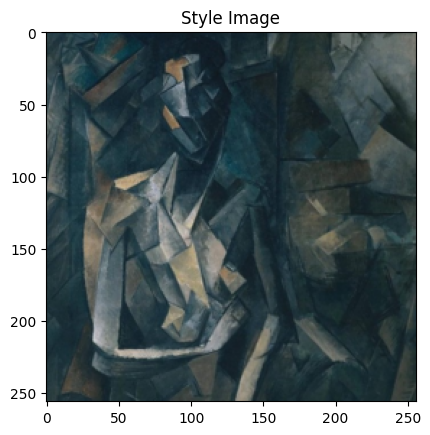

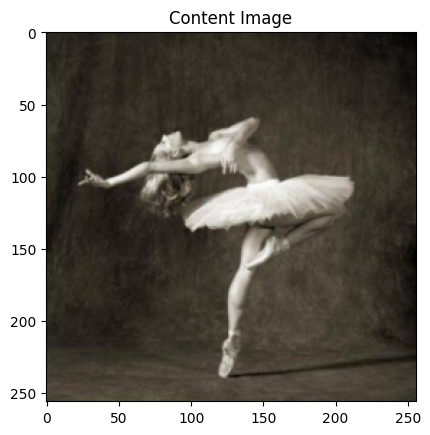

In [91]:
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Loss'ы


In [6]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()

        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

## Style Loss


In [7]:
def gram_matrix(input):
    a, b, c, d = input.size()  #


    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [8]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Загрузка модели

In [9]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 223MB/s]  


In [10]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])


class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):

        return (img - self.mean) / self.std

In [11]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):

    normalization = Normalization(normalization_mean, normalization_std)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  #
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)

            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:

            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:

            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [94]:
input_img = content_img.clone()

## Алгоритм Гатиса

In [13]:
def get_input_optimizer(input_img):

    optimizer = optim.LBFGS([input_img])
    return optimizer

In [14]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    input_img.requires_grad_(True)

    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    #print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():

            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            #if run[0] % 50 == 0:
                #print("run {}:".format(run))
                #print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                #    style_score.item(), content_score.item()))
                #print()

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp(0, 1)

    return input_img

Запуск


In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

## Оба лосса хорошо стабильно падают, изображение, действительно с перенесенным стилем, все работает корректно

## Литература
 - https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

# Теперь замерим качество метрикой FID на датасете vangogh2photo

In [15]:
!wget "http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/vangogh2photo.zip"
!unzip -q vangogh2photo.zip -d dataset

--2024-10-08 13:57:00--  http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/vangogh2photo.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 306590349 (292M) [application/zip]
Saving to: 'vangogh2photo.zip'

vangogh2photo.zip   100%[===================>] 292.39M  4.54MB/s    in 59s     

2024-10-08 13:57:59 (4.97 MB/s) - 'vangogh2photo.zip' saved [306590349/306590349]



In [16]:
def convert_to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [17]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_) # применяем необходимые трансформации
        self.unaligned = unaligned
        self.root_A = root[0]
        self.root_B = root[1]

        self.files_A = sorted(glob.glob(self.root_A + "/*.*"))
        self.files_B = sorted(glob.glob(self.root_B + "/*.*"))

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        if image_A.mode != "RGB":
            image_A = convert_to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = convert_to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)

        # Возвращаем словарь
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [35]:
val_transforms_ = [
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
]

In [32]:
def generate_images(dataloader, output_path, device):
    os.makedirs(output_path, exist_ok=True)
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            real_B = batch['B']  # Входные изображения
            input_B = real_B.clone()
            real_B = real_B.to(device)
            input_B = input_B.to(device)
            real_A = batch['A'].to(device)

            generated_B = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            real_B, real_A, input_B)

            generated_image = generated_B.cpu()
            generated_image = transforms.ToPILImage()(generated_image.squeeze(0))
            generated_image.save(f"{output_path}/generated_{i}.png")

def save_vangogh_images(dataloader, output_path):
    os.makedirs(output_path, exist_ok=True)
    for i, batch in enumerate(tqdm(dataloader)):
        real_A = batch['A']
        real_A = real_A.cpu().clamp(0, 1)
        real_image = transforms.ToPILImage()(real_A.squeeze(0))
        real_image.save(f"{output_path}/real_{i}.png")

In [36]:
val_loader = DataLoader(
    ImageDataset(root= ['dataset/vangogh2photo/testA', 'dataset/vangogh2photo/testB'], transforms_=val_transforms_),
    batch_size=1,
    shuffle=False,
    num_workers=2)

In [ ]:
save_vangogh_images(val_loader, 'vangogh_images1')

In [37]:
generate_images(val_loader, "generated_images3", device)

100%|██████████| 751/751 [1:25:36<00:00,  6.84s/it]


In [39]:
fid_value = fid_score.calculate_fid_given_paths(['dataset/vangogh2photo/trainB', "generated_images3"], batch_size=1, device=device, dims=2048)

print(f"FID: {fid_value}")

100%|██████████| 751/751 [00:15<00:00, 47.98it/s]


FID: 176.11807134539467


## Как видно, данный алгоритм больше передает художественный стиль, и поэтому FID = 176 близости к реальным фото очень высок, больше чем у CycleGAN. То есть он выдает изображениия больше похожие на картины, чем на фото, но при этом, теряется некоторая информация с фото, поданного на вход